### - Install
 conda create -n langgraph_agent python=3.12

 pip install -U openai langchain langgraph matplotlib pandas ipython pydantic

 pip install langchain_openai langchain-anthropic

### - then just run 🛌🏻🔭

### https://docs.langchain.com/oss/python/langgraph/overview

In [ ]:
import sys
import os
import io
import re
import contextlib
import traceback
import matplotlib.pyplot as plt
import glob
from IPython.display import display, Image, Markdown, HTML
import base64
import time

# Config 参数
MAX_ITERATIONS = 2 # Reviewer 最大迭代次数
MULTI_MODAL_REVIEW = False # 是否启用多模态 Review 看图片
ALTERNATIVE_NUM = 2 # Consultant 生成的备选方案数量
MAX_COMMENTS = 5 # Reviewer 每轮最多评论数
ConsModule_ON = True # 是否启用 Consultant 模块
CUT_OUTEXT = 2000  # 截断输出文本的最大字符数 

# display funcs
def collapsible_mardown(title: str, content: str):
    """
    创建一个可折叠的 Markdown 区块，用于展示长文本内容。
    """
    html_content = f"""
    <details>
      <summary><strong>{title}</strong></summary>
      <pre style="white-space: pre-wrap;">{content}</pre>
    </details>
    """
    display(HTML(html_content))


# SAVE func
def save_response_toMD(resp: dict, oput_file: str = "temp_final_report.md"):
    try:
        with open(oput_file, "w", encoding="utf-8") as f:
            f.write(f"### 🛌🏻 Re4gent with Multi-Modal Review\n\n")
            f.write(f"#### Configs 🏷️:\nMaxCount: {MAX_ITERATIONS}, MultiModalReview: {MULTI_MODAL_REVIEW}, AlternativeNum: {ALTERNATIVE_NUM}, MaxComments: {MAX_COMMENTS}, ConsModule_ON: {ConsModule_ON}, CUT_OUTEXT: {CUT_OUTEXT}\n\n")
            for key, value in resp.items():
                f.write(f"### {key}\n")
                if isinstance(value,list):
                    for i,item in enumerate(value):
                        if key == "python_codes":
                            f.write(f"\n#### Script block{i+1}:\n")
                            f.write(f"\n{item}\n\n")

                        elif key == "runtime_outputs":
                            f.write(f"\n#### Output block{i+1}\n")
                            f.write(f"\n{item}\n\n")
                        else:
                            f.write(f"\tCurrent Stage [{chr(i+96+1).upper()}/{len(value)}]\n{item}\n\n")
                    f.write("\n\n")
                else:
                    f.write(f"{str(value)}\n\n")
        print(f"✅ 保存成功: {oput_file}")
    except Exception as e:
        print(f"❌ {oput_file}保存失败: {e}")


# text truncate func
def truncate_outext(text: str, max_chars: int = 800) -> str:
    """
    高效截断过长文本：保留开头和结尾，中间替换
    """
    if not text:
        return ""
        
    if len(text) <= max_chars:
        return text
        
    head_len = max_chars // 2
    tail_len = max_chars // 2
    
    # 字符串切片，内存开销最小
    return (
        text[:head_len] 
        + f"\n\n... [Truncated: Content too long ({len(text)} chars). Hidden middle part.] ...\n\n" 
        + text[-tail_len:]
    )



# 设置工作区
WORKSPACE = "./workspace"
os.makedirs(WORKSPACE, exist_ok=True)

def execute_code_tool(code_input: str) -> str:
    """
    执行 Python 代码并捕获输出（stdout/stderr）和错误。
    会自动切换到 workspace 目录以保存图片。
    """
    # 1. 代码去除 ```python 标记
    # code = code_input.strip()
    # if code.startswith("```"):
    #     lines = code.split('\n')
    #     if len(lines) >= 2:
    #         code = '\n'.join(lines[1:-1])

    pattern = r"```python.*?\s+(.*?)(?:```|$)"
    # re.DOTALL 让 . 可以匹配换行符，re.IGNORECASE 忽略 python 大小写
    match = re.search(pattern, code_input, re.DOTALL | re.IGNORECASE)
    if match:
        code = match.group(1).strip()
    else:
        # 如果没匹配到 python 标记，尝试匹配裸的 ```
        pattern_bare = r"```.*?\s+(.*?)(?:```|$)"
        match_bare = re.search(pattern_bare, code_input, re.DOTALL)
        if match_bare:
            code = match_bare.group(1).strip()
        else:
            # 兜底：如果完全没有 markdown 标记，假设整段文本就是代码
            code = code_input.strip()
    # 如果代码是空的，直接返回
    if not code:
        return "Error: No executable code found."


    # 2. 执行环境
    output_capture = io.StringIO()
    # 限制 global 作用域，但保留必要的 builtins
    local_scope = {}
    global_scope = {"__name__": "__main__", "__builtins__": __builtins__}

    # 保存当前目录，执行完后切回来
    original_cwd = os.getcwd()
    
    try:
        # 切换到工作目录, plt.savefig('fig.png') 就会存在这里
        os.chdir(WORKSPACE)
        
        # 清理旧图片
        for f in glob.glob("*.png"): os.remove(f)

        # 3. 执行代码并重定向输出
        with contextlib.redirect_stdout(output_capture), contextlib.redirect_stderr(output_capture):
            exec(code, global_scope, global_scope)
            
        raw_result = output_capture.getvalue()
        result = truncate_outext(raw_result, max_chars=CUT_OUTEXT)

    except Exception as e:
        # 捕获 Traceback，这对 Reviewer 修复 bug 非常重要
        tb_str = traceback.format_exc()
        raw_result = output_capture.getvalue() + f"\nRuntime Error:\n{tb_str}"
        result = truncate_outext(raw_result, max_chars=CUT_OUTEXT)

    finally:
        # 恢复目录
        os.chdir(original_cwd)
        # 关闭所有 plot，防止内存泄漏
        plt.close('all')

    return result

def load_image_tool():
    """
    从 workspace 读取最新生成的图片，以可折叠 Markdown 展示。
    """
    image_files = glob.glob(os.path.join(WORKSPACE, "*.png")) + \
                  glob.glob(os.path.join(WORKSPACE, "*.jpg"))
    
    image_files.sort(key=os.path.getmtime)
    
    if not image_files:
        return None

    ### Markdown 折叠展示
    # display(Markdown("#### 📊 Generated Visualization"))
    # for img_path in image_files:
    #     print(f"Loaded: {os.path.basename(img_path)}")        
    #     display(Image(filename=img_path))

    # 构建折叠内容
    img_html = ""
    for img_path in image_files:
        filename = os.path.basename(img_path)

        img_html += f'<p><b>{filename}</b></p>\n'
        img_html += f'<img src="{img_path}" style="max-width:50%; height:auto; margin:10px 0;">\n'

    # 用 details 折叠
    collapsible_html = f"""
    <details>
        <summary><b>Generated Visualization ({len(image_files)} image(s)) 📊</b></summary>
        <div style="padding: 10px; margin-top: 5px; border-left: 2px solid #ddd;">
            {img_html}
        </div>
    </details>
    """
    
    display(HTML(collapsible_html))
    return image_files

def encode_image_tool(image_path: str):
    """
    图片编码为 base64 字符串，作为输入用于Review
    """
    with open(image_path, "rb") as img_file:
        encoded_string = base64.b64encode(img_file.read()).decode('utf-8')
    return encoded_string


# LLM 设置
os.environ['LANGCHAIN_TARCING_V2'] = 'true'
os.environ['LANGCHAIN_ENDPOINT'] ='http://api.smith.langchain.com'
os.environ['LANGCHAIN_API_KEY'] = 'Your_LangChain_API_Key_Here'

os.environ['OPENAI_API_KEY'] = 'Your_ChatAnywhere_API_Key_Here'
os.environ['OPENAI_API_BASE'] = 'https://api.chatanywhere.tech/v1'


from langchain_openai import ChatOpenAI
model = ChatOpenAI(model = 'gpt-5-mini', temperature=0)
# print(model.profile)


In [ ]:
# State Definition

from pydantic import BaseModel, Field
from langchain.messages import HumanMessage, SystemMessage, ToolMessage
from typing_extensions import TypedDict, Literal
from typing import Annotated, List
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image, Markdown
import operator


class State(TypedDict):
    # --- Problem ---
    prob_todo: str

    # --- Design Section ---
    expanded_prob: str
    solution_plans: List[str]
    
    # --- Execution Section ---
    technical_spec: Annotated[List[str], operator.add]
    python_codes: Annotated[List[str], operator.add]
    runtime_outputs: Annotated[List[str], operator.add]
    
    # --- Review Section ---
    review_decision: Literal["accept", "revise"]
    review_comments: Annotated[List[str], operator.add]
    iteration_count: int

    # --- Review multimodal IMAGE ---
    rev_image_description: Annotated[List[str], operator.add]  



######## 
class solu_plan(BaseModel):
    solu_name: str = Field(description="Short title of the solution strategy")
    content: str = Field(description=
            "Structured formulation in concise pseudocode or numbered steps style.\n"
            "Requirements:\n"
            "- governing idea\n"
            "- algorithmic steps\n"
            "- stability / accuracy / complexity / efficiency limitations\n"
            "STRICT CONSTRAINT: \n"
            "-Do not directly provide Python script here."
            "-Stop immediately after the limitations sections."
        )

class Consultant_module(BaseModel):
    expanded_prob: str = Field( description=
        "Elaborate on the original problem outline while preserving its core meaning.\n"
        "Explicitly indentify the primary mathematical and numerical challenges."
            )
    solution_plans: List[solu_plan] = Field( description=
        f"Provide {ALTERNATIVE_NUM} alternative solution strategies. Do not write long continuous paragraphs."
        )

llm1_stru_consu = model.with_structured_output(Consultant_module)


########
class Progarmmer_module(BaseModel):
    technical_spec: str = Field(description = 
            "Concise architectural overview for rapid comprehension of core algorithm and data flow."
    )
    python_codes: str = Field(description=
            "A complete, bug-free Python script.\n"
            "Requirements:\n"
            "- Enclosed in a single ```python ... ``` markdown block.\n"
            "- The content INSIDE the markdown block MUST be PURE PYTHON CODE ONLY.\n"
            "- All required imports included at the top.\n"            
            "- Modular structure with clear function definitions.\n"
            "- Use brief, clear code comments, avoid verbose or tutorial-style explanations.\n"
            "- Do NOT rebuild or modify matrices inside the time loop; do it ONCE at the start.\n"
            "- Must include quantitative outputs: printed metrics (e.g., error norm) or labeled plots (with axes, title)."
        )

llm2_stru_prog = model.with_structured_output(Progarmmer_module)


########
class review_spec(BaseModel):
    category: Literal["runtime","structure","accuracy",] = Field( description=
            "Specify the type of issue being addressed.\n"
            "- runtime: Execution errors or failures\n"
            "- structure: Code organization or quality\n" 
            "- accuracy: Numerical stability, precision, convergence, or error behavior\n"
            "MAJOR/MINOR Issues inferred from image-based review MUST be re-categorized based on their underlying cause (runtime, structure, or accuracy)."
            )
    issue: str = Field( description= "A concrete issue identified.")
    severity: Literal["MINOR", "MAJOR"] = Field( description=
            "Severity of the issue:\n"
            "- MINOR: Cosmetic, stylistic, or secondary issues that do not affect correctness or results\n"
            "- MAJOR: Issues that cause runtime failure, non-physical behavior, incorrect conclusions, or invalid results."
            )
    recommendation: str = Field( description= "Specific suggestions for improvement and refinement.")

class Reviewer_module(BaseModel):
    review_decision: Literal["accept", "revise"] = Field( description=
            "Accept only if:\n"         
            "- code runs without errors\n"
            "- numerical results are correct and quantitatively accurate\n"
            "- no MAJOR issues are identified."
            "Revise only if:\n"
            "- there is any runtime error or the results are fundamentally wrong.\n"
            "- any MAJOR issue exists, including those inferred from image-based review."
            )
    review_comments: List[review_spec] = Field( description=
            f"Provide up to {MAX_COMMENTS} specific review comments.\n"
            "If accepting, leave list empty or provide optional suggestions.\n"
            "If revising, provide a comprehensive list covering all identified issues.\n"
            "Each comment must identify a concrete issue.\n"
            "Vague or ambiguous feedback is not allowed."
            )

llm3_stru_reviewer = model.with_structured_output(Reviewer_module)


######## 
class ImageIssueItem(BaseModel):
    issue_item: str = Field(description=
        "Concrete problem or discrepancy observed in the image.\n"
        "MUST refer to incorrect or implausible trends, magnitudes, spatial patterns, continuity, physical behaviors."
    )
    severity: Literal["MINOR", "MAJOR"] = Field(description=
        "Severity of the issue:\n"
        "- MINOR: Cosmetic or secondary issue. Does not affect physical validity or main results.\n"
        "- MAJOR: Non-physical behavior or clearly abnormal image indicating numerical or modeling failure."
    )

class single_rev_img_spec(BaseModel):
    img_name: str = Field(description=
        "Filename of the reviewed image."
    )
    img_content: str = Field(description=
        "Evaluation of the image, focus on:\n"
        "- consistency with problem requirements\n"
        "- primary quantities or fields shown"
    )
    img_issue: List[ImageIssueItem] = Field(description=
        "List of issues. Leave empty if no concrete problems are found."
    )

class Reivew_multimodal_image(BaseModel):
    image_description: List[single_rev_img_spec] = Field(description=
        "Structured description of each provided image."
    )

llm3_stru_rev_image = model.with_structured_output(Reivew_multimodal_image)

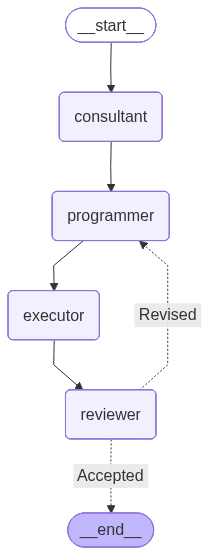

In [ ]:
# GRAPH

def llm_call_c1(state: State):
    display(Markdown(f"### 🛌🏻 pdeAgent with Multi-Modal Review"))
    collapsible_mardown("Configs 🏷️", f"MaxCount: {MAX_ITERATIONS}\nImageReview: {MULTI_MODAL_REVIEW}\nAPIkey: sk-0kWZkCND4QyB0rXz6IgzuurYoI4KsaDCphH2juRTTjV2Sjgl\nPlanNum: {ALTERNATIVE_NUM}\nMaxRevComs: {MAX_COMMENTS}\nConsModule_ON: {ConsModule_ON}\nCUT_OUTEXT: {CUT_OUTEXT}")
    if ConsModule_ON:
        display(Markdown("### 🧠 Consultant:"))
        sys_msg = (
            "You are a distinguished Mathematical Consultant and Numerical Analyst.\n"
            "[Task] Expand the context of a given scientific problem and generate multiple alternative solution options.\n"        
            "[Goal] Accurately dissect the problem by preserving its original meaning, explicitly identifying the underlying mathematical and numerical challenges, and formulating rigorous and well-structured solution strategies."        
        )
        cons_response = llm1_stru_consu.invoke([
            SystemMessage(content= sys_msg),
            HumanMessage(content=f"[Problem Statement]:\n{state["prob_todo"]}"),
        ])


        plans_text = "\n".join(
            f"{i+1}. {pl.solu_name}:\n{pl.content}\n\n" for i,pl in enumerate(cons_response.solution_plans)
        )
        dict_text = {pl.solu_name:pl.content for pl in cons_response.solution_plans}
        # No need to store titles    
        plans_title = "\n".join(dict_text.keys())
        # print(f"Multiple Plans:\n\n{plans_title}")
        collapsible_mardown(f"Multiple Plans:", plans_text)

        return {
            "expanded_prob":cons_response.expanded_prob,
            "solution_plans": cons_response.solution_plans,
            "iteration_count": 0,
        }
    else:
        return {"iteration_count": 0,
                "expanded_prob": "",
                "solution_plans": [],}


def llm_call_p2(state: State):
    display(Markdown("### 👨‍💻 Programmer Generating:"))
    sys_msg_coder = ("You are an expert Python Programmer specialized in scientific computing.\n"
                )
    
    human_msg_coder = (
                f"[Problem Statement]:\n{state['prob_todo']}\n"
                )

    if ConsModule_ON:
        plans_text = "\n".join(
            f"{i+1}. {pl.solu_name}:\n{pl.content}\n\n" for i,pl in enumerate(state["solution_plans"])
            )
        add_first_sys_msg = (
            "[Task] For a specific problem description and the associated candidate solving algorithms, select an appropriate algorithm and implement it in Python to resolve the problem.\n"       
            "[Goal] Produce a complete, well-structured, and executable Python script that correctly realizes the selected algorithm, with clear modular organization and quantitative outputs suitable for verification."     
            )
        human_msg_coder += (
                f"[Expanded Problem]:\n{state['expanded_prob']}\n\n"
                f"[Solution Plans]:\n{plans_text}"
                )
    else:
        add_first_sys_msg = (
            "[Task] For a specific problem description, implement an appropriate algorithm in Python to resolve the problem.\n"       
            "[Goal] Produce a complete, well-structured, and executable Python script that correctly realizes the solution, with clear modular organization and quantitative outputs suitable for verification."     
            )


    add_rev_sys_msg = (
                    "[Task] Revise the [Previous Code] based on the provided execution results and structured review comments.\n"       
                    "[Goal] When revising the [Previous Code], you MUST:\n"
                    "- Analyze the error trace to identify the underlying root cause of the previous failure.\n"
                    "- Address Recommendations from the [Review Comments] EXACTLY."
                    )


    ###     if Revised, after fist time
    is_revision = state.get("iteration_count", 0) > 0
    if is_revision:
        last_code = state["python_codes"][-1] if state["python_codes"] else "N/A"
        last_Runtime_opt = state["runtime_outputs"][-1] if state["runtime_outputs"] else "N/A"
        last_comments = state["review_comments"][-1] if state["review_comments"] else "N/A"
        last_tech_details = state["technical_spec"][-1] if state["technical_spec"] else "N/A"

        feedback_text = (
            f"[Technical Details]:\n{last_tech_details}\n"
            f"[Previous Code]:\n{last_code}\n"
            f"[Runtime Output]:\n{last_Runtime_opt}\n"
            f"[Review Comments] need addressed:\n{last_comments}"
        )

        progm_response = llm2_stru_prog.invoke([
        SystemMessage(content= sys_msg_coder + add_rev_sys_msg),
        HumanMessage(content=(
            f"[Problem Statement]:\n{state['prob_todo']}\n"            
            f"{feedback_text}")
            )
        ])
        # display(Markdown(f"#### 📝 Python script revised:\n{progm_response.python_codes}"))
        collapsible_mardown(f"Python script revised{state["iteration_count"]} 📝:", progm_response.python_codes)
        return {
            "technical_spec": [progm_response.technical_spec],
            "python_codes": [progm_response.python_codes],}


    ###     First time
    progm_response = llm2_stru_prog.invoke([
        SystemMessage(content= sys_msg_coder + add_first_sys_msg),
        HumanMessage(content= human_msg_coder)
        ])    
    # display(Markdown(f"#### 🗒️ Python script:\n{progm_response.python_codes}"))
    collapsible_mardown("Python script 🗒️:", progm_response.python_codes)
    return {
        "technical_spec": [progm_response.technical_spec],
        "python_codes": [progm_response.python_codes],}


def run_codes(state: State):
    display(Markdown("#### ⚙️ Executing"))
    Last_code_to_run = state["python_codes"][-1]  # 运行最新的代码
    runtime_output = execute_code_tool(Last_code_to_run)
    # display(Markdown(f"#### 🖥️ Runtime outputs:"))
    # print(f"{runtime_output}")
    collapsible_mardown("Runtime outputs 🖥️:", runtime_output)

    #Related images: show and review
    latest_img = load_image_tool()

    img_review_text = ""
    content_img_prompt = []
    if MULTI_MODAL_REVIEW and latest_img:
        image_rev_sys_msg = (
            "You are a Scientific Visualization Expert and Numerical Analyst.\n"
            "Analyze the generated images based on the problem statement and the corresponding Python script."
            )
        intro_msg = (
            f"[Problem statement]:\n{state['prob_todo']}\n"
            f"[Submitted Code]:\n{Last_code_to_run}\n"
            f"[Runtime Output]:\n{runtime_output}\n"
            f"Review the following {len(latest_img)} provided images\n"
        )
        content_img_prompt.append({"type": "text", "text": intro_msg})

        for n,img_path in enumerate(latest_img):
            encoded_img = encode_image_tool(img_path)
            file_name = os.path.basename(img_path)
            content_img_prompt.append({"type":"text", "text": f"Image {n+1} Filename: {file_name}\n"})
            content_img_prompt.append(
                {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_img}",
                    }
                })
            
        display(Markdown("### 🔭🗂️ Multimodal Image Review:"))

        response_img_review = llm3_stru_rev_image.invoke([
                SystemMessage(content= image_rev_sys_msg),
                HumanMessage(content = content_img_prompt),
            ])

        for m,desc in enumerate(response_img_review.image_description):
                img_review_text += f"Image {m+1} Filename: {desc.img_name}\n"
                img_review_text += f"\n[Description]: {desc.img_content}\n"
                
                ### Issues list
                if desc.img_issue:
                    issues_list = []
                    for i, issue in enumerate(desc.img_issue):
                        
                        issues_list.append(f"{i+1}. {issue.severity}\n{issue.issue_item}")
                    img_review_text += f"\n[Identified Issues]:\n" + "\n".join(issues_list) + "\n\n"
                else:
                    img_review_text += "Identified Issues: None\n\n"

        # display(Markdown(f"#### 🖼️ Image-based Review:\n{img_review_text}"))
        collapsible_mardown("Image-based Review 🖼️:", img_review_text)

    return {
        "runtime_outputs": [runtime_output],
        "rev_image_description": [img_review_text]
    }

def llm_call_r3(state: State):
    display(Markdown("### 🧐 Reviewer:"))
    latest_code = state["python_codes"][-1]
    latest_output = state["runtime_outputs"][-1]
    latest_techSpec = state["technical_spec"][-1]
    iter_count = state.get("iteration_count", 0) + 1
    
    latest_img_review = state["rev_image_description"][-1] if state.get("rev_image_description") and MULTI_MODAL_REVIEW else ""

    sys_msg_reviewer = (
        "You are a Code Reviewer and Scientific Computing Expert.\n"
        "[Task] Review the reliability of numerical results and the quality of code implementation.\n"
        "[Goal] Conduct a structured review assessment based on the problem description, submitted code, and runtime output.\n"
        "Be pragmatic in your decision: if results are reasonable, accept it. But if you request a REVISE, you must be thorough and list all technical blockers."
    )

    content_parts = [f"[Problem Statement]:\n{state['prob_todo']}\n"]
    if ConsModule_ON:
        content_parts.append(f"[Expanded Problem]:\n{state['expanded_prob']}\n")
    content_parts.extend([
        f"[Code Submitted]:\n{latest_code}\n",
        f"[Technical Details]:\n{latest_techSpec}\n",
        f"[Runtime Output]:\n{latest_output}\n",
        f"[Image-based Review]:\n{latest_img_review}"
    ])
    human_msg_content = "".join(content_parts)


    review_response = llm3_stru_reviewer.invoke([
        SystemMessage(content= sys_msg_reviewer),
        HumanMessage(content= human_msg_content)
    ])

    comments_text = "\n".join(
        f"{i+1}. {comment.severity}\n\nCategory: {comment.category}\nIssue: {comment.issue}\n\nRecommendation: {comment.recommendation}\n\n"
        for i, comment in enumerate(review_response.review_comments)
    )
    display(Markdown(f"#### 📧📨📥 Decision: {review_response.review_decision.upper()}"))
    # display(Markdown(f"#### 📝 Review Comments:\n{comments_text}"))
    collapsible_mardown("Review Comments 📝:", comments_text)

    return {
        "review_decision": review_response.review_decision,
        "review_comments": [comments_text],
        "iteration_count": iter_count}


def decide_next_step(state: State):
    decision = state["review_decision"]
    iter_count = state.get("iteration_count", 0)

    if decision == "accept":
        display(Markdown(f"#### ✅ Accepted after {iter_count}/{MAX_ITERATIONS} iters."))
        return "Accepted"

    if iter_count > MAX_ITERATIONS:
        display(Markdown(f"#### 🛑 Max iterations {iter_count}/{MAX_ITERATIONS} reached. Stopping."))
        return "Accepted"

    display(Markdown(f"#### 🔄 Revision requested (Iteration {iter_count}/{MAX_ITERATIONS}). Back to Programmer."))
    return "Revised"


agent_builder = StateGraph(State)
agent_builder.add_node("consultant", llm_call_c1)
agent_builder.add_node("programmer", llm_call_p2)
agent_builder.add_node("executor", run_codes)
agent_builder.add_node("reviewer", llm_call_r3)


agent_builder.add_edge(START, "consultant")
agent_builder.add_edge("consultant", "programmer")
agent_builder.add_edge("programmer", "executor")

agent_builder.add_edge("executor", "reviewer")

agent_builder.add_conditional_edges(
    "reviewer",
    decide_next_step,
    {
        "Accepted": END,
        "Revised": "programmer", 
    },
)


agent_graph = agent_builder.compile()

display(Image(agent_graph.get_graph().draw_mermaid_png()))


In [ ]:
# problem statements

burgers_problem = r"""
The PDE of 1-D Burgers equation is given by:
\begin{cases}
u_t + u u_x - \nu u_{xx} = 0, & (x,t) \in \Omega \\
\end{cases}

The parameter is \(\nu = \frac{0.01}{\pi}\).
The domain is \(\Omega = [-1, 1] \times [0, 1]\).
The initial and boundary conditions are:
\begin{cases}
u(x, 0) = -\sin(\pi x), & (x,t) \in \Omega \text{ with } t = 0 \\
u(-1, t) = u(1, t) = 0, & (x,t) \in \Omega \\
\end{cases}

Implement a stable and efficient method to solve this problem.
Define visc = 1.0 / Re at the GLOBAL scope (outside main), and strictly use visc instead of nu throughout the code to avoid confusion with u.
Ensure all constants are passed explicitly to functions or defined globally to prevent NameError.
Plot the contour of the velocity magnitude using 'RdBu_r' colormap) and velocity profile at timesteps t=0.2,0.4,0.6,0.8,1.0 in only one figure.
Just save figs do not use plt.show() in the code.
Do not use 'np.trapz' as it is removed in NumPy 2.0, implement the integration manually.
"""


cavity_flow_problem = r"""
The PDE of 2-D steady incompressible Navier-Stokes equations is given by:
\begin{cases}
u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + \frac{\partial p}{\partial x} - \frac{1}{\mathrm{Re}} \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) = 0, (x,y) \in \Omega,\\
u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + \frac{\partial p}{\partial y} - \frac{1}{\mathrm{Re}} \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) = 0, (x,y) \in \Omega,\\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0, (x,y) \in \Omega,\\
\end{cases}
The Reynolds number Re = 400.
The domain is $\Omega = [0,1]^2$, the top boundary is $\Gamma_1$, the left, right and bottom boundary is $\Gamma_2$.
The boundary conditions are:
\begin{cases}
(u,v) = (\alpha(x(1-x)), 0) &(x,y) \in \Gamma_1\\
(u,v) = (0,0) &(x,y) \in \Gamma_2\\
\text{Reference pressure: } p(0,0) = 0\\
\end{cases}
where $\alpha$ is 2.

Implement a stable and efficient method to solve this problem.
Implement reasonable acceleration strategies to reduce computational cost.
Define visc = 1.0 / Re at the GLOBAL scope (outside main), and strictly use visc instead of nu throughout the code to avoid confusion with u.
Ensure all constants are passed explicitly to functions or defined globally to prevent NameError.
Plot the contour of the velocity magnitude using the 'RdBu_r' colormap, overlaid with streamlines, and the convergence history in one figure.
Just save figs do not use plt.show() in the code.

[HINTS]:
Never use the keyword argument 'tol' in any SciPy solver. Always use 'atol'. 
Print concise progress information ONLY every 10% of total steps.
Focus on generating runnable code with reasonable physical results, do not over-optimize.
Do NOT conclude [not converged] solely because max_iters is reached, assess convergence based on whether residuals are still decreasing. 
"""


sod_shock_problem = r"""
The Euler equations for compressible flow in 1-D are given by:
\begin{cases}
\frac{\partial \rho}{\partial t} + \frac{\partial (\rho u)}{\partial x} = 0, \\
\frac{\partial (\rho u)}{\partial t} + \frac{\partial (\rho u^2 + p)}{\partial x} = 0, \\
\frac{\partial (\rho E)}{\partial t} + \frac{\partial (\rho E u + p u)}{\partial x} = 0,
\end{cases}
in the interval \( x \in [0,1] \), where \( E = \frac{1}{2} u^2 + \frac{p}{(\gamma - 1)\rho} \), \( \gamma = 1.4 \).
At \( t = 0 \), the initial condition is
(\rho, u, p) = 
\begin{cases}
(1.0, 0.0, 1.0), & 0 < x \leq 0.5, \\
(0.125, 0.0, 0.1), & 0.5 \leq x < 1,
\end{cases}

Implement a stable and efficient method to solve this problem.
Strictly use visc instead of nu throughout the code to avoid confusion with u.
Ensure all constants are passed explicitly to functions or defined globally to prevent NameError.
Plot the density, velocity, and pressure at t=0.1,0.2,0.3 in three figures, respectively.
Just save figs do not use plt.show() in the code.

[HINTS]:
Print diagnostic information that helps assess the physical correctness of the solution, such as shock position and the absence of spurious oscillations.
Global conservation outputs are intended for qualitative reference only and should not be treated as strict acceptance criteria.
Do not use 'np.trapz' as it is removed in NumPy 2.0, implement the integration manually.
"""


longTm_NS_problem = r"""
The governing PDEs for 2D unsteady incompressible NS equations with explicit forcing are given by:
\begin{cases}
\frac{\partial u }{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + \frac{\partial p}{\partial x} - \frac{1}{\mathrm{Re}} \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) = f_x, (x,y) \in \Omega,\\
\frac{\partial v }{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + \frac{\partial p}{\partial y} - \frac{1}{\mathrm{Re}} \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) = f_y, (x,y) \in \Omega,\\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0, (x,y) \in \Omega,\\
\end{cases}

The Reynolds number Re = 100.
The domain is $\Omega = [0, 2] \times [0, 1]$.
The forcing term $f = (f_x, f_y)$ is given by:
\begin{equation}
f_x = 0, \quad f_y = -\sin(\pi x) \sin(\pi y) \sin(\pi t).
\end{equation}

The boundary conditions are:
[Top/Bottom Walls] ($y=0$ and $y=1$): No-slip condition
$(u, v) = (0, 0)$.
[Inlet] (Left, $x=0$):
$u(0, y, t) = \sin(\pi y) \left(\sin(\pi t) + \sin(3\pi t) + \sin(5\pi t) \right)$
$v(0, y, t) = 0$
[Outlet] (Right, $x=2$):
Homogeneous Neumann for velocity: $\frac{\partial u}{\partial x} = 0, \frac{\partial v}{\partial x} = 0$
Dirichlet for pressure: $p(2, y, t) = 0$
The initial condition is $u(x, y, 0) = v(x, y, 0) = 0$ everywhere.

Implement a stable and efficient method to solve this problem.
Implement reasonable acceleration strategies to reduce computational cost.
Define visc = 1.0 / Re at the GLOBAL scope (outside main), and strictly use visc instead of nu throughout the code to avoid confusion with u.
Ensure all constants are passed explicitly to functions or defined globally to prevent NameError.
Simulate until t=1.0. Plot contours of u, v, and p at the final step in one figure using 'RdBu_r' colormap.
Just save figs do not use plt.show() in the code.

[HINTS]:
Never use the keyword argument 'tol' in any SciPy solver. Always use 'atol'. 
Do not use 'np.trapz' as it is removed in NumPy 2.0.
Use indexing='ij' for meshgrid and order='F' for all ravel/reshape operations to ensure consistent shapes and correct coordinate alignment.
Use Chorin's projection method on a Staggered (MAC) Grid using the upwind scheme to ensure stability.
Focus on generating runnable code with reasonable physical results, do not over-optimize.
Print concise progress information ONLY every 10% of total steps.
"""


poison_problem = r"""
The PDE of Poisson 2D equation is given by:
\begin{cases}
-\Delta u = 0 \\
\end{cases}
The domain is a rectangle minus four circles \(\Omega = \Omega_{\text{rec}} \setminus R_i\) where \(\Omega_{\text{rec}} = [-0.5, 0.5]^2\) is the rectangle and \(R_i\) denotes four circle areas:
\begin{cases}
R_1 = \left\{ (x,y) : (x - 0.3)^2 + (y - 0.3)^2 \leq 0.1^2 \right\} \\
R_2 = \left\{ (x,y) : (x + 0.3)^2 + (y - 0.3)^2 \leq 0.1^2 \right\} \\
R_3 = \left\{ (x,y) : (x - 0.3)^2 + (y + 0.3)^2 \leq 0.1^2 \right\} \\
R_4 = \left\{ (x,y) : (x + 0.3)^2 + (y + 0.3)^2 \leq 0.1^2 \right\} \\
\end{cases}

The boundary condition is
\begin{cases}
u = 0,\, x \in \partial R_i \\
u = 1,\, x \in \partial \Omega_{\text{rec}} \\
\end{cases}

Implement a stable and efficient method to solve this problem.
Strictly use visc instead of nu throughout the code to avoid confusion with u.
Ensure all constants are passed explicitly to functions or defined globally to prevent NameError.
Plot the contours of the velocity magnitude in one figure using 'RdBu_r' colormap, and mark the circles in the plot.
Just save figs do not use plt.show() in the code.

[HINTS]:
Address the geometric challenges of curved boundaries using appropriate techniques (e.g., Immersed Boundary Method).
Print necessary solving information to facilitate the reliability check of the solution. 
"""


helmholtz_problem = r"""
The PDE of Poisson-Boltzmann(Helmholtz) 2D equation is given by:
\begin{equation}
-\Delta u + k^2 u = f(x,y)
\end{equation}
The function f(x) is defined as:
\begin{equation}
f(x)=A\cdot\left(\sum_{i}\mu_{i}^{2}+x_{i}^{2}\right)\sin(\mu_{1}\pi x_{1})\sin(\mu_{2}\pi x_{2})
\end{equation}
The parameter values are:
\begin{equation}
\mu_1 = 1,\quad \mu_2 = 4,\quad k = 8,\quad A = 10
\end{equation}

The domain is \(\Omega = [- 1,1]^{2}\) with several circles removed.
The circles \(\Omega_{\text{circle}} = \bigcup_{i = 1}^{4} R_i\) are defined as:
\begin{cases}
R_{1}=\left\{(x,y):(x - 0.5)^{2}+(y - 0.5)^{2}\leq0.2^{2}\right\}\\
R_{2}=\left\{(x,y):(x - 0.4)^{2}+(y + 0.4)^{2}\leq0.4^{2}\right\}\\
R_{3}=\left\{(x,y):(x + 0.2)^{2}+(y + 0.7)^{2}\leq0.1^{2}\right\}\\
R_{4}=\left\{(x,y):(x + 0.6)^{2}+(y - 0.5)^{2}\leq0.3^{2}\right\}\\
\end{cases}
The boundary conditions are:
\begin{cases}
u = 0.2, & x\in\partial\Omega_{\text{rec}}\\
u = 1, & x\in\partial\Omega_{\text{circle}}
\end{cases}

Implement a stable and efficient method to solve this problem.
Strictly use visc instead of nu throughout the code to avoid confusion with u.
Ensure all constants are passed explicitly to functions or defined globally to prevent NameError.
Plot the contour of u in one figure using 'RdBu_r' colormap, and mark the circles in the plot.
Just save figs do not use plt.show() in the code.

[HINTS]:
Use 'atol' to avoid TypeError: gmres()/cg() got an unexpected keyword argument 'tol'.
Address the geometric challenges of curved boundaries using appropriate techniques (e.g., Immersed Boundary Method).
Print necessary solving information to facilitate the reliability check of the solution.
"""


cylinder_problem = r"""
The governing PDEs for 2D incompressible flow around a cylinder are given by:
\begin{cases}
\frac{\partial u }{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} + \frac{\partial p}{\partial x} - \frac{1}{\mathrm{Re}} \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right) = 0, (x,y) \in \Omega,\\
\frac{\partial v }{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} + \frac{\partial p}{\partial y} - \frac{1}{\mathrm{Re}} \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right) = 0, (x,y) \in \Omega,\\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0, (x,y) \in \Omega,\\
\end{cases}

The computational domain \Omega is a rectangle with:
\begin{cases}
Cylinder diameter d = 1.0 (Normalized length scale)\
Distance from cylinder center to left boundary: x_1 = 3.0\
Distance from cylinder center to right boundary: x_2 = 8.0\
Distance from cylinder center to top/bottom boundaries: y_1 = y_2 = 3.0\
Total domain size: (x_1 + x_2) \times (y_1 + y_2)\
\end{cases}
The boundary conditions are:
\begin{cases}
Inlet \Gamma_{in} (left): (u,v) = (1, 0) constant inflow\
Walls \Gamma_{top} \cup \Gamma_{bottom}: (u,v) with \frac{\partial u}{\partial y}=0, v=0 (Free-slip condition)\
Cylinder Surface: No-slip condition\
Outlet \Gamma_{out}: zero pressure gradient\
\end{cases}
The Reynolds number Re = 100 (Based on diameter and inlet velocity). 

Please implement a stable and efficient method to solve this problem.
Implement reasonable acceleration strategies to reduce computational cost.
Define visc = 1.0 / Re at the GLOBAL scope (outside main), and strictly use visc instead of nu throughout the code to avoid confusion with u.
Ensure all constants are passed explicitly to functions or defined globally to prevent NameError.
Simulate until t=20.0. Plot the contour of the velocity magnitude at the final step in one figure using 'RdBu_r' colormap, and mark the cylinder in the plot. 
Just save figs do not use plt.show() in the code.

[HINTS]:
Never use the keyword argument 'tol' in any SciPy solver. Always use 'atol'.
Do not use 'np.trapz' as it is removed in NumPy 2.0.
Use indexing='ij' for meshgrid and order='F' for all ravel/reshape operations to ensure consistent shapes and correct coordinate alignment.
Fix the pressure at one single node to remove the nullspace singularity.
Use the Immersed Boundary Method with volume penalization on a Staggered (MAC) Grid. Treat the penalization term implicitly in the momentum matrix diagonal to avoid restrictive time-steps.
Rely solely on the penalization term to enforce the no-slip condition on the cylinder surface.
Focus on generating runnable code with reasonable physical results, do not over-optimize.
Print concise progress information ONLY every 10% of total steps.
"""


hilbert_mat_problem = r"""
Implement various stable and accurate methods from scratch to solve the system of linear algebra equations $H_n \mathbf{x} = \mathbf{b}$ accurately and efficiently, 
where $H_n$ is an $n \times n$ matrix defined by $H_n(i,j) = \frac{1}{i + j - 1}$, and the vector $\mathbf{b}$ is taken to ensure that the system admits an exact solution $\mathbf{x}^* = (x_i)_{n \times 1} = (1)_{n \times 1}$.

Compare the $L_\infty$ error of the numerical results with the exact solution $\mathbf{x}^*$ for $n = 5, 10, 15, 20, 25$.
Plot the $L_\infty$ error versus $n$ in one figure with linear scale for both axes. Just save figs do not use plt.show() in the code.
"""


Keyhole_problem = r"""
Please read the CSV data file from path: ./dataset_keyhole.csv and consider the data in columns 3, 4, 5, 6, 7, 8 and 11.
These columns correspond to seven physical quantities respectively:
the effective laser power (eta P), the laser scan speed (V_s), the laser beam radius (r_0), the thermal diffusivity (alpha), the material density (rho), the heat capacity (C_p), and the difference between melting and ambient temperatures (T_l-T_0).

Based on dimensional analysis and using the data of these physical quantities in the file, please identify the optimal dimensionless quantity formed by combining these parameters, which exhibits the highest coefficient of determination (R-squared) and thus dominates the variation in the keyhole aspect ratio e*.

Implement a roubust and reliable method from scratch for this data-driven dimensional analysis. 
Ensure that the the resulting dimensionless exponents are normalized by V_s and that the exponents of physical quantities be integers or rational fractions with absolute values not exceeding 3.

Plot one figure with linear scale for both axes to visualize the correlation between the optimal dimensionless quantity and e*.
Just save figs do not use plt.show() in the code.
To read the data file, just use df = pd.read_csv(file_path) without any additional parameters.
"""

